# Copulas generation

In [165]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.sandbox.distributions.multivariate import multivariate_t_rvs
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from copulas.univariate import GaussianKDE

In [177]:
prices = pd.read_csv('data/log_prices.csv', index_col=0)
prices.index = pd.to_datetime(prices.index, format='%Y%m%d')
prices = prices.dropna()
columns = prices.columns
prices.head()

,brn,cl,ho,xrb
date,,,,
2015-01-05,0.010676,0.025528,-0.023495,0.032481
2015-01-12,-0.039646,-0.081290,-0.008362,-0.018356
2015-01-19,0.082589,0.041151,0.022561,0.087349
2015-01-26,0.117570,0.118920,0.091463,0.075879
2015-02-02,0.056883,0.012610,0.069970,0.039044


## Definition

Modeling of a copula. Given a random vector $(X_1, \dots, X_d)$, the copula is defined as a PDF of the form

$$C(u_1, \dots, u_n) = \mathbb P(X_1 \leq F^{-1}_1(u_1), \dots, X_d \leq F^{-1}_d(u_d))$$

where $F^{-1}_i$ is a reverse CDF of $X_i$ RV and $u_i$ is a i-th marginal CDF value.

## Distributions copula + marginals

Copulas:
* Student t
* Gaussian

Marginals:
* Gaussian
* Student t
* Gaussian KDE
* Empirical

### Student t marginals fitting

In [178]:
t_param = {'brn': stats.t.fit(prices.brn), 
         'cl': stats.t.fit(prices.cl), 
         'ho': stats.t.fit(prices.ho), 
         'xrb': stats.t.fit(prices.xrb)}
pd.DataFrame(t_param, index=['df', 'loc', 'scale']).T

,df,loc,scale
brn,4.717482,0.001396,0.036572
cl,35.155460,0.000365,0.045774
ho,5.572727,0.000280,0.033830
xrb,5.853887,-0.000273,0.040088


### Gaussian marginals fitting

In [179]:
gaussian_param = {'brn': stats.norm.fit(prices.brn), 
         'cl': stats.norm.fit(prices.cl), 
         'ho': stats.norm.fit(prices.ho), 
         'xrb': stats.norm.fit(prices.xrb)}
pd.DataFrame(gaussian_param, index=['loc', 'scale']).T

,loc,scale
brn,0.001138,0.046847
cl,0.000323,0.047128
ho,0.000150,0.041608
xrb,-0.000070,0.050156


### Gaussian KDE marginals fitting

In [180]:
kde_marginals = {}
for i in columns:
    X = prices[i].values
    kde = GaussianKDE()
    kde.fit(X)
    kde_marginals[i] = kde

## t copula

In [181]:
cov = prices.cov().values
prices.cov()

,brn,cl,ho,xrb
brn,0.002205,0.001975,0.001657,0.001698
cl,0.001975,0.002232,0.001533,0.001564
ho,0.001657,0.001533,0.001740,0.001302
xrb,0.001698,0.001564,0.001302,0.002528


In [182]:
df = pd.DataFrame(t_param, index=['df', 'loc', 'scale']).T['df'].mean()
df

12.824888934187008

Generating 10000 observations from the t distribution

In [183]:
norm_sample = multivariate_t_rvs([0, 0, 0, 0], cov, df, 10000)

Uniform transformation

In [184]:
unif_sample = []
for i, i_sample in enumerate(norm_sample.T):
    unif_sample.append(stats.t.cdf(i_sample, df=df, loc=0, scale=cov[i][i]**(1/2)))
unif_sample = np.array(unif_sample)

### t copula: t marginals

In [185]:
gen_prices = {}
for i, col in enumerate(columns):
    df, loc, scale = t_param[col]
    gen_prices[col] = stats.t.ppf(unif_sample[i], df, loc, scale)

gen_prices = pd.DataFrame(gen_prices, columns=columns)
gen_prices['type'] = 'generated'
prices['type'] = 'real'

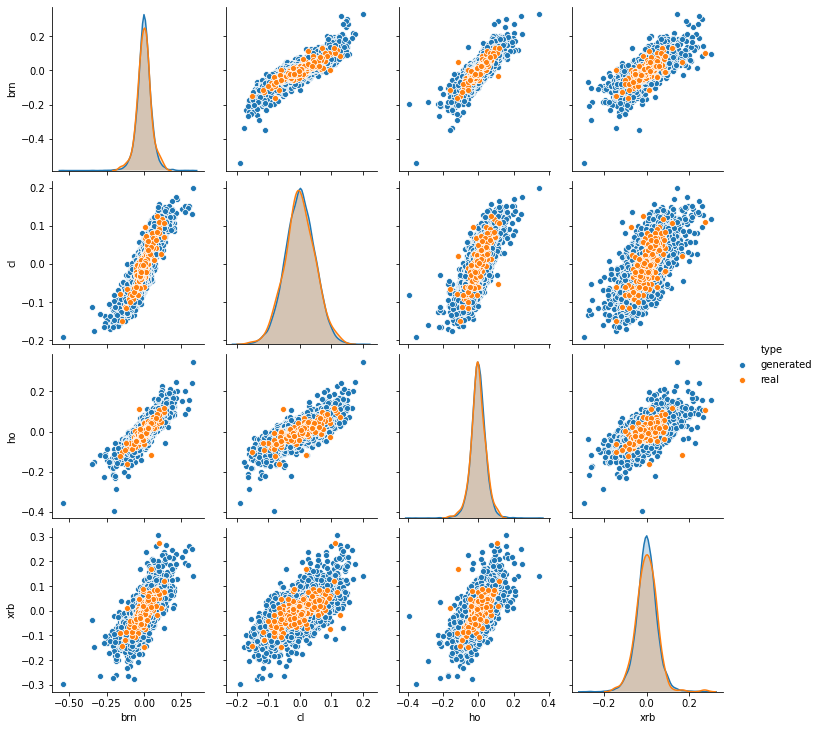

In [186]:
sns.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()

### t copula: Gaussian marginals

In [139]:
gen_prices = {}
for i, col in enumerate(columns):
    loc, scale = gaussian_param[col]
    gen_prices[col] = stats.norm.ppf(unif_sample[i], loc, scale)

gen_prices = pd.DataFrame(gen_prices, columns=columns)
gen_prices['type'] = 'generated'
prices['type'] = 'real'

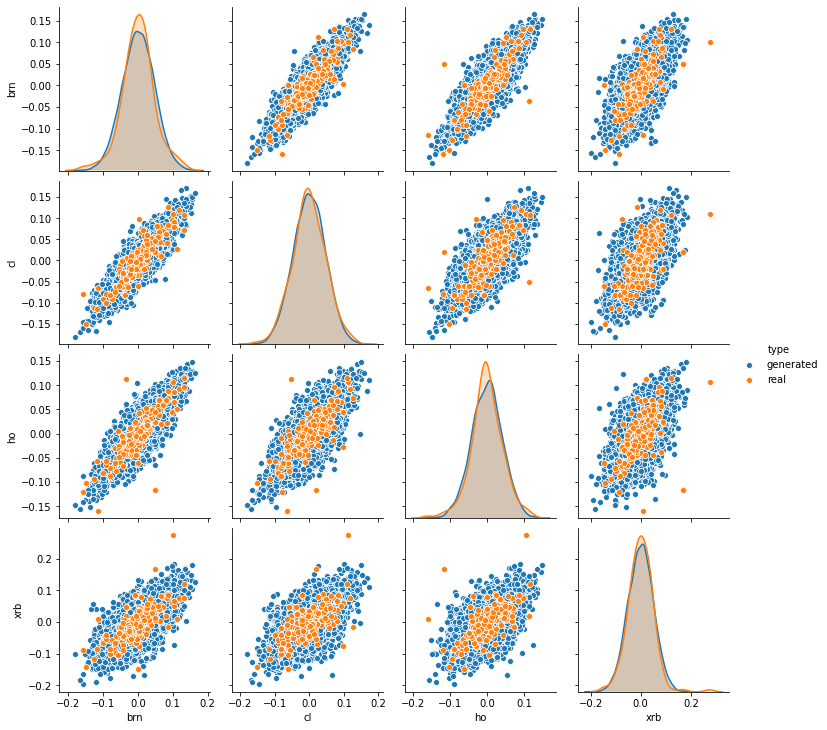

In [140]:
sns.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()

### t copula: Gaussian KDE marginals

In [142]:
gen_prices = {}
for i, col in enumerate(columns):
    gen_prices[col] = kde_marginals[col].percent_point(unif_sample[i])

gen_prices = pd.DataFrame(gen_prices, columns=columns)
gen_prices['type'] = 'generated'
prices['type'] = 'real'

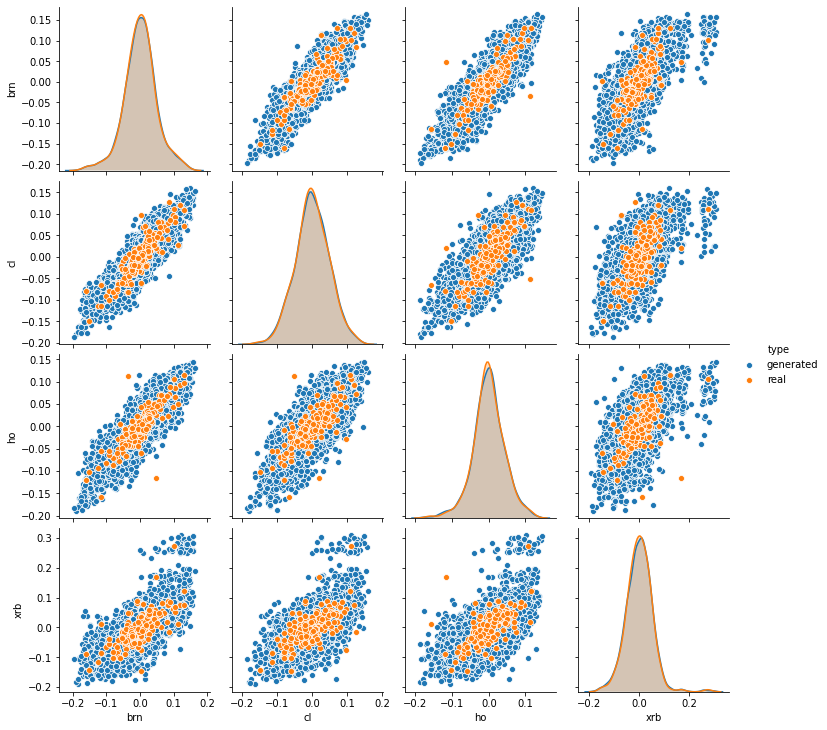

In [143]:
sns.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()

### t copula: empirical marginals

In [151]:
gen_prices = {}
for i, col in enumerate(columns):
    gen_prices[col] = np.quantile(prices[col], unif_sample[i])

gen_prices = pd.DataFrame(gen_prices, columns=columns)
gen_prices['type'] = 'generated'
prices['type'] = 'real'

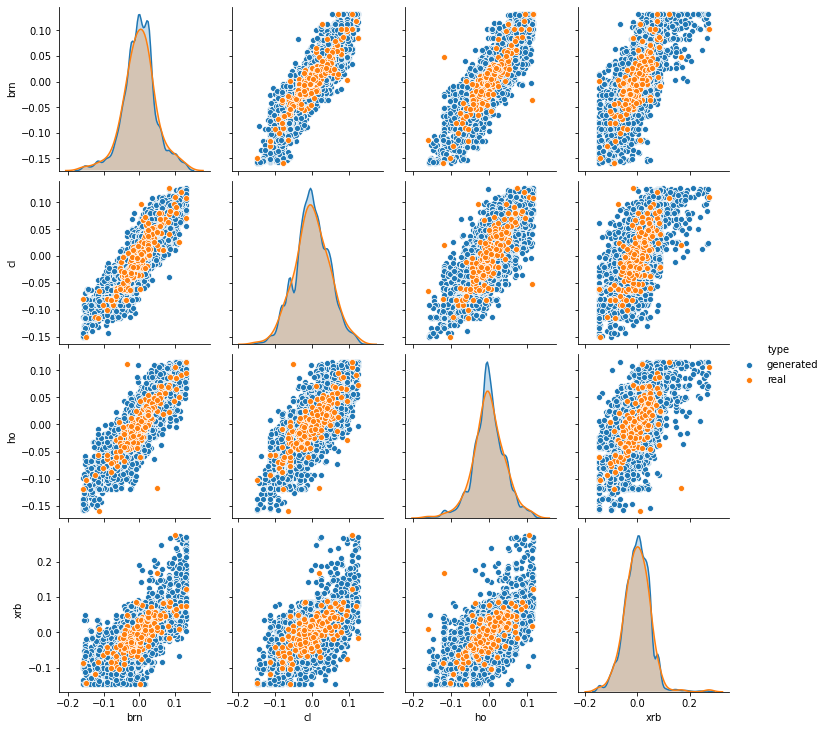

In [152]:
sns.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()

## Gaussian copula

Generating 10000 observations from the Normal distribution

In [155]:
cov = np.array(prices.cov())
norm_sample = np.random.multivariate_normal([0, 0, 0, 0], cov, size=10000)

Uniform transformation

In [156]:
unif_sample = []
for i, i_sample in enumerate(norm_sample.T):
    unif_sample.append(stats.norm.cdf(i_sample, loc=0, scale=cov[i][i]**(1/2)))
unif_sample = np.array(unif_sample)

### Gaussian copula: t marginals

In [157]:
gen_prices = {}
for i, col in enumerate(columns):
    df, loc, scale = t_param[col]
    gen_prices[col] = stats.t.ppf(unif_sample[i], df, loc, scale)

gen_prices = pd.DataFrame(gen_prices, columns=columns)
gen_prices['type'] = 'generated'
prices['type'] = 'real'

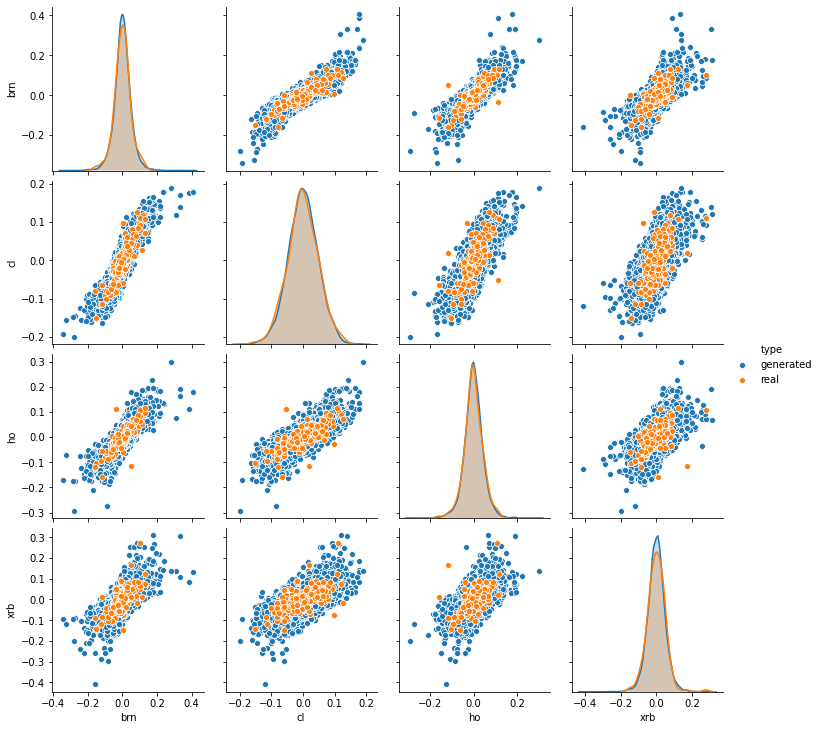

In [158]:
sns.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()

### Gaussian copula: Gaussian marginals

In [159]:
gen_prices = {}
for i, col in enumerate(columns):
    loc, scale = gaussian_param[col]
    gen_prices[col] = stats.norm.ppf(unif_sample[i], loc, scale)

gen_prices = pd.DataFrame(gen_prices, columns=columns)
gen_prices['type'] = 'generated'
prices['type'] = 'real'

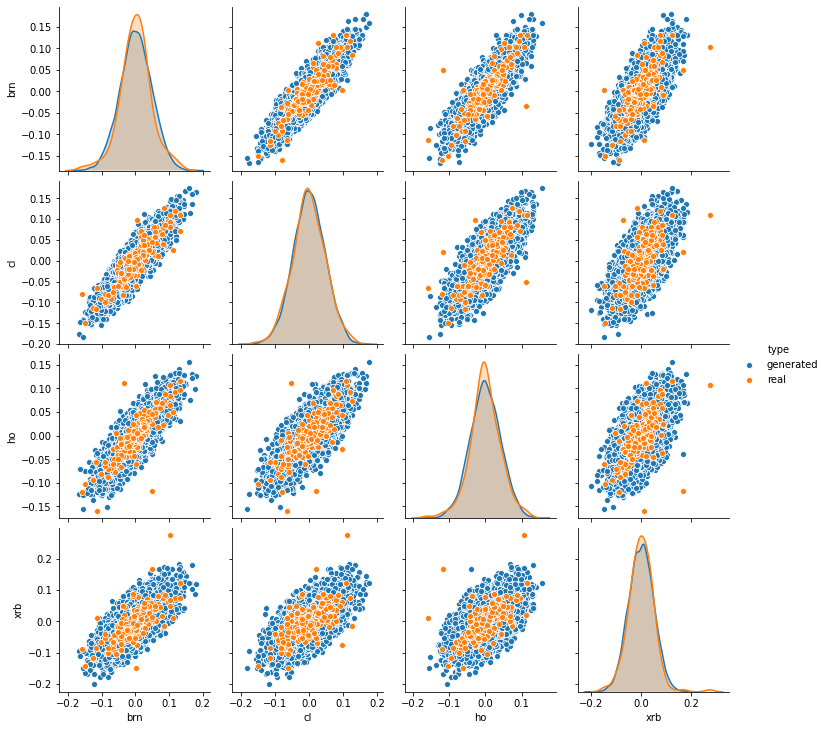

In [160]:
sns.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()

### Gaussian copula: Gaussian KDE marginals

In [161]:
gen_prices = {}
for i, col in enumerate(columns):
    gen_prices[col] = kde_marginals[col].percent_point(unif_sample[i])

gen_prices = pd.DataFrame(gen_prices, columns=columns)
gen_prices['type'] = 'generated'
prices['type'] = 'real'

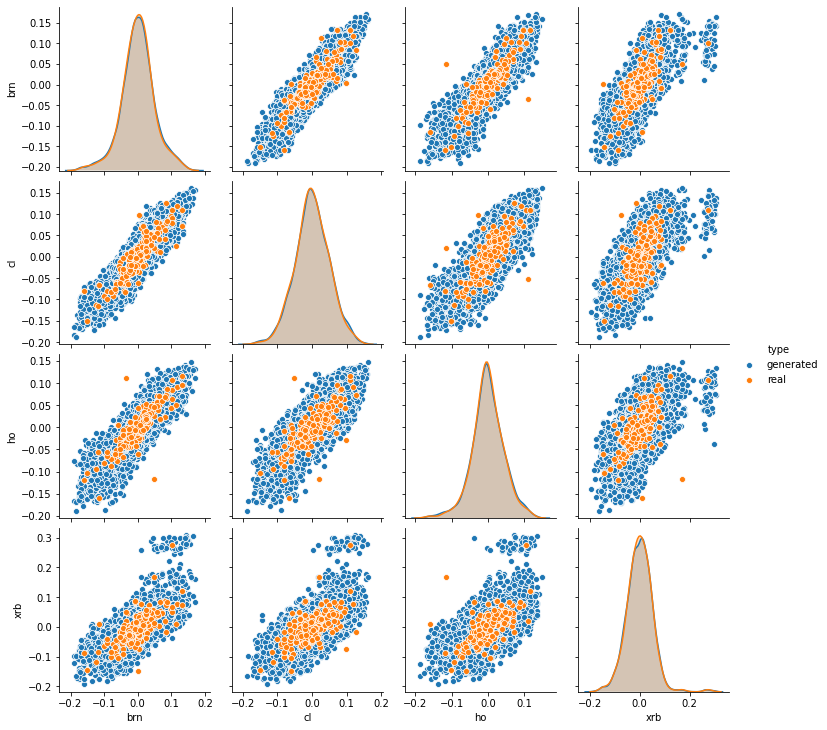

In [162]:
sns.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()

### Gaussian copula: empirical marginals

In [163]:
gen_prices = {}
for i, col in enumerate(columns):
    gen_prices[col] = np.quantile(prices[col], unif_sample[i])

gen_prices = pd.DataFrame(gen_prices, columns=columns)
gen_prices['type'] = 'generated'
prices['type'] = 'real'

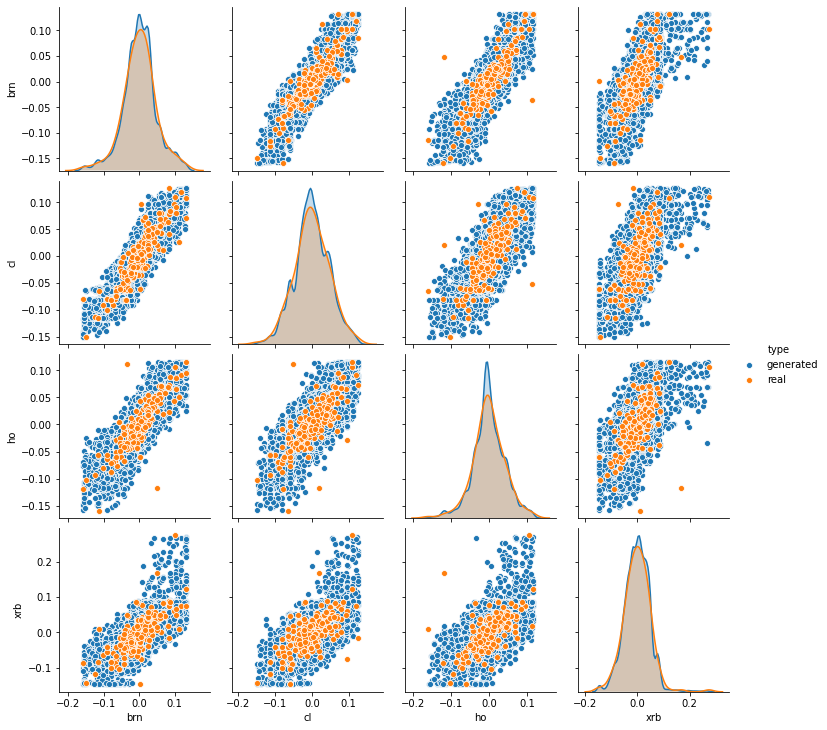

In [164]:
sns.pairplot(pd.concat([gen_prices, prices]), hue="type")
plt.show()